In [1]:
#import all needed libraries
import pandas as pd
import requests
import numpy as np
from datetime import datetime
import time
from pygam import GAM, InvGaussGAM, GammaGAM, LinearGAM, s, l, f, te
import matplotlib.pyplot as plt
import math
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import random
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
import altair as alt

In [2]:
#read data from csv
land_data = pd.read_csv('DecentralandLandDataFinal.csv', index_col = 0)
land_data.head()

,id,sale price (MANA),timestamp,type,category,Estate Size,Date,adjacentRoadCount,MANA price (USD),ETH price (USD),sale price (USD),Closest Plaza,Dist to Plaza,Closest District,Dist to District,X,Y
0,1,100000.0,1539280016,order,estate,2,2018-10-11,0.0,0.074934,225.662016,7493.396964,SW Genesis,36.0,Fashion Street,88,-100,-107
1,2,100000.0,1539280356,order,estate,2,2018-10-11,0.0,0.074934,225.662016,7493.396964,SW Genesis,36.0,Fashion Street,88,-100,-107
2,3,32000.0,1539287969,order,parcel,1,2018-10-11,0.0,0.074934,225.662016,2397.887029,N Genesis,61.0,Vegas City,4,-70,145
3,4,30000.0,1539329807,order,parcel,1,2018-10-12,0.0,0.067969,192.001084,2039.081627,C Genesis,18.0,Bittrex Tomorrow,29,-27,-21
4,5,15000.0,1539334568,order,parcel,1,2018-10-12,0.0,0.067969,192.001084,1019.540813,E Genesis,19.0,Dragon City,11,65,-28


In [4]:
def find_r_theta(data):
    """This function converts cartesian coordinates to polar coordinates :
    ------------
    data: This function will be used in a df.apply and each row of the df will sent through
    this function
    return:
    -------
    the r and theta for the polar coordinates
    """
    #calculate r
    r = math.sqrt(data['X']**2+data['Y']**2)
    
    #calculate theta, if x is 0, special case
    if data['X'] == 0:
        if data['Y'] > 0: 
            theta = math.pi/2
        elif data['Y'] < 0:
            theta = -1*math.pi/2
        else: 
            theta = 0
    #if x not 0, then calculate theta
    else:
        theta = math.atan(data['Y']/data['X'])
    
    return r, theta

In [5]:
#calculate r and theta
land_data[['r','theta']] = land_data.apply(find_r_theta, axis = 1, result_type = 'expand')

land_data.head()

,id,sale price (MANA),timestamp,type,category,Estate Size,Date,adjacentRoadCount,MANA price (USD),ETH price (USD),sale price (USD),Closest Plaza,Dist to Plaza,Closest District,Dist to District,X,Y,r,theta
0,1,100000.0,1539280016,order,estate,2,2018-10-11,0.0,0.074934,225.662016,7493.396964,SW Genesis,36.0,Fashion Street,88,-100,-107,146.454771,0.819202
1,2,100000.0,1539280356,order,estate,2,2018-10-11,0.0,0.074934,225.662016,7493.396964,SW Genesis,36.0,Fashion Street,88,-100,-107,146.454771,0.819202
2,3,32000.0,1539287969,order,parcel,1,2018-10-11,0.0,0.074934,225.662016,2397.887029,N Genesis,61.0,Vegas City,4,-70,145,161.012422,-1.121037
3,4,30000.0,1539329807,order,parcel,1,2018-10-12,0.0,0.067969,192.001084,2039.081627,C Genesis,18.0,Bittrex Tomorrow,29,-27,-21,34.205263,0.661043
4,5,15000.0,1539334568,order,parcel,1,2018-10-12,0.0,0.067969,192.001084,1019.540813,E Genesis,19.0,Dragon City,11,65,-28,70.774289,-0.406747


In [6]:
#Creating baseline model: average sale price by estate size
by_size = land_data.groupby(land_data['Estate Size']).agg({"sale price (USD)" : "mean"})
print(by_size.loc[1,"sale price (USD)"])
by_size

5707.612270047244


,sale price (USD)
Estate Size,
1,5.707612e+03
2,1.201709e+04
3,1.533668e+04
4,2.995152e+04
5,1.602576e+04
6,3.563647e+04
7,2.291902e+04
8,3.462176e+04
9,5.715953e+04


In [7]:
#make predictions based on estate size
land_data['Pred_size'] = land_data.apply(lambda x: (by_size.loc[x['Estate Size'],"sale price (USD)"]), axis=1)
land_data

,id,sale price (MANA),timestamp,type,category,Estate Size,Date,adjacentRoadCount,MANA price (USD),ETH price (USD),sale price (USD),Closest Plaza,Dist to Plaza,Closest District,Dist to District,X,Y,r,theta,Pred_size
0,1,100000.0,1539280016,order,estate,2,2018-10-11,0.0,0.074934,225.662016,7493.396964,SW Genesis,36.0,Fashion Street,88,-100,-107,146.454771,0.819202,12017.086395
1,2,100000.0,1539280356,order,estate,2,2018-10-11,0.0,0.074934,225.662016,7493.396964,SW Genesis,36.0,Fashion Street,88,-100,-107,146.454771,0.819202,12017.086395
2,3,32000.0,1539287969,order,parcel,1,2018-10-11,0.0,0.074934,225.662016,2397.887029,N Genesis,61.0,Vegas City,4,-70,145,161.012422,-1.121037,5707.612270
3,4,30000.0,1539329807,order,parcel,1,2018-10-12,0.0,0.067969,192.001084,2039.081627,C Genesis,18.0,Bittrex Tomorrow,29,-27,-21,34.205263,0.661043,5707.612270
4,5,15000.0,1539334568,order,parcel,1,2018-10-12,0.0,0.067969,192.001084,1019.540813,E Genesis,19.0,Dragon City,11,65,-28,70.774289,-0.406747,5707.612270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13392,24988,3500.0,1681823123,order,parcel,1,2023-04-18,1.0,0.691581,2077.535665,2420.531816,Pixel 1,12.0,Dragon City,75,-1,-122,122.004098,1.562600,5707.612270
13393,24989,2875.0,1681908647,order,parcel,1,2023-04-19,0.0,0.685122,2103.278814,1969.726168,Pixel 1,18.0,Dragon City,76,-2,-114,114.017543,1.553254,5707.612270
13394,24990,3985.0,1681908659,order,parcel,1,2023-04-19,1.0,0.685122,2103.278814,2730.211750,Pixel 1,18.0,Dragon City,75,-1,-114,114.004386,1.562025,5707.612270
13395,24991,2150.0,1681908707,order,parcel,1,2023-04-19,0.0,0.685122,2103.278814,1473.012613,SE Gensis,33.0,Dragon City,0,96,-104,141.534448,-0.825377,5707.612270


In [8]:
#encode the variables that are factors, change string factors to numbers
label_encoder = preprocessing.LabelEncoder()
  
# Encode labels in column 'Closest Plaza'.
land_data['Closest Plaza Label']= label_encoder.fit_transform(land_data['Closest Plaza'])
land_data['Closest Plaza Label'].unique()

array([ 9,  2,  0,  1,  4,  8,  3, 10,  6,  7,  5])

In [9]:
# Encode labels in column 'Closest District'.
land_data['Closest District Label']= label_encoder.fit_transform(land_data['Closest District'])
  
land_data['Closest District Label'].unique()

array([18, 35,  4, 13, 10, 11, 14, 20,  1,  8, 22, 23,  3, 32,  9,  6, 29,
       15, 17, 37,  0, 24, 33, 31, 27, 19,  7, 36, 12,  5, 25, 28, 30, 26,
       21, 38,  2, 34, 16])

In [10]:
# Encode labels in column 'type'.
land_data['type Label']= label_encoder.fit_transform(land_data['type'])
  
land_data['type Label'].unique()

array([1, 0])

In [11]:
len(land_data['Closest District Label'].unique())
land_data

,id,sale price (MANA),timestamp,type,category,Estate Size,Date,adjacentRoadCount,MANA price (USD),ETH price (USD),...,Closest District,Dist to District,X,Y,r,theta,Pred_size,Closest Plaza Label,Closest District Label,type Label
0,1,100000.0,1539280016,order,estate,2,2018-10-11,0.0,0.074934,225.662016,...,Fashion Street,88,-100,-107,146.454771,0.819202,12017.086395,9,18,1
1,2,100000.0,1539280356,order,estate,2,2018-10-11,0.0,0.074934,225.662016,...,Fashion Street,88,-100,-107,146.454771,0.819202,12017.086395,9,18,1
2,3,32000.0,1539287969,order,parcel,1,2018-10-11,0.0,0.074934,225.662016,...,Vegas City,4,-70,145,161.012422,-1.121037,5707.612270,2,35,1
3,4,30000.0,1539329807,order,parcel,1,2018-10-12,0.0,0.067969,192.001084,...,Bittrex Tomorrow,29,-27,-21,34.205263,0.661043,5707.612270,0,4,1
4,5,15000.0,1539334568,order,parcel,1,2018-10-12,0.0,0.067969,192.001084,...,Dragon City,11,65,-28,70.774289,-0.406747,5707.612270,1,13,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13392,24988,3500.0,1681823123,order,parcel,1,2023-04-18,1.0,0.691581,2077.535665,...,Dragon City,75,-1,-122,122.004098,1.562600,5707.612270,5,13,1
13393,24989,2875.0,1681908647,order,parcel,1,2023-04-19,0.0,0.685122,2103.278814,...,Dragon City,76,-2,-114,114.017543,1.553254,5707.612270,5,13,1
13394,24990,3985.0,1681908659,order,parcel,1,2023-04-19,1.0,0.685122,2103.278814,...,Dragon City,75,-1,-114,114.004386,1.562025,5707.612270,5,13,1
13395,24991,2150.0,1681908707,order,parcel,1,2023-04-19,0.0,0.685122,2103.278814,...,Dragon City,0,96,-104,141.534448,-0.825377,5707.612270,8,13,1


In [12]:
#split to train and test data
random.seed(1111)
land_data_train, land_data_test = train_test_split(land_data, test_size=0.2)
print(land_data_train.shape,land_data_test.shape)

(10717, 23) (2680, 23)


In [156]:
#print min and max sale prices
print(min(land_data['sale price (USD)']))
print(max(land_data['sale price (USD)']))

0.0322221724033154
2315502.1467209


In [14]:
#get X and y for training the models
X = land_data_train[['type Label','Estate Size', 'adjacentRoadCount', 'MANA price (USD)', 'ETH price (USD)',
                     'Closest Plaza Label', 'Dist to Plaza', 'Closest District Label', 'Dist to District','r','theta']]
y = land_data_train[['sale price (MANA)']]

#fit a linearGAM to the data
gam = LinearGAM(f(0) + s(1) + s(2) + s(3) + s(4) + f(5) + s(6) + f(7) + s(8) + s(9) + s(10)).fit(X,y)
#gam = LinearGAM()
gam = gam.gridsearch(X, y)

100% (11 of 11) |########################| Elapsed Time: 0:00:10 Time:  0:00:10


In [15]:
X

,type Label,Estate Size,adjacentRoadCount,MANA price (USD),ETH price (USD),Closest Plaza Label,Dist to Plaza,Closest District Label,Dist to District,r,theta
5753,1,1,0.0,0.090778,390.789135,1,24.0,32,4,49.729267,0.264488
7825,1,1,0.0,1.301456,2647.158190,9,59.0,18,66,155.322246,0.579074
8516,1,1,0.0,0.750513,2888.732274,2,45.0,0,7,130.188325,1.134633
8775,1,1,1.0,1.043579,3943.256785,7,19.0,13,66,110.290525,-1.498197
1854,1,1,0.0,0.037170,122.938608,9,34.0,18,86,120.933866,1.051650
...,...,...,...,...,...,...,...,...,...,...,...
8726,1,1,0.0,0.994659,3936.163392,9,21.0,29,20,62.265560,0.521138
12747,1,1,0.0,0.836656,1665.791907,8,58.0,13,0,155.595630,-0.977446
12424,1,1,1.0,0.981870,1794.539626,4,21.0,15,7,56.302753,-0.583077
5416,0,1,1.0,0.042198,243.707821,6,7.0,13,56,126.289350,-1.427779


In [16]:
#get summary info
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                    187.5791
Link Function:                     IdentityLink Log Likelihood:                               -229041.6658
Number of Samples:                        10717 AIC:                                           458460.4899
                                                AICc:                                          458467.2818
                                                GCV:                                         787859389.074
                                                Scale:                                      763076936.9742
                                                Pseudo R-Squared:                                   0.6949
Feature Function                  Lam

C:\Users\Bamar\AppData\Local\Temp\ipykernel_22484\3358381670.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


In [17]:
#gam.gridsearch(X, y)

<Figure size 640x480 with 0 Axes>

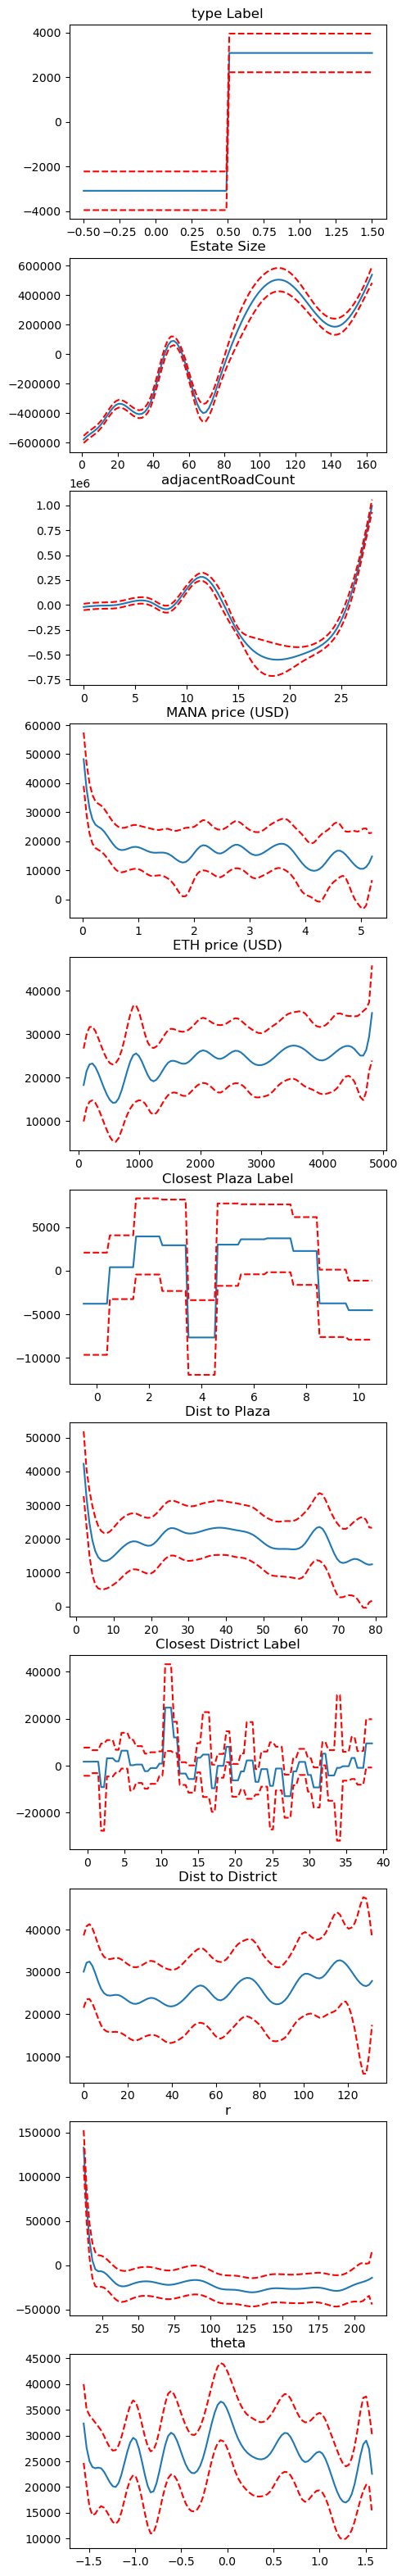

In [102]:
## plot the marginal plots
plt.figure();

fig, axs = plt.subplots(11,1);
#fig, axs = plt.subplots(4,3);
#fig.set_size_inches(10,50)
fig.set_size_inches(5,40)

titles = ['type Label','Estate Size', 'adjacentRoadCount', 'MANA price (USD)', 'ETH price (USD)',
          'Closest Plaza Label', 'Dist to Plaza', 'Closest District Label', 'Dist to District','r','theta']
for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
    #if i == 0:
        #ax.set_ylim(-30,30)
    ax.set_title(titles[i]);

In [19]:
X.shape[1]

11

In [20]:
#make y2 the response in USD, y is respons in MANA
y2 = land_data_train[['sale price (USD)']]

#fit another LinearGAM to X and y2
gam2 = LinearGAM(f(0) + s(1) + s(2) + s(3) + s(4) + f(5) + s(6) + f(7) + s(8) + s(9) + s(10)).fit(X,y2)
#gam = LinearGAM()
gam2 = gam2.gridsearch(X, y2)

100% (11 of 11) |########################| Elapsed Time: 0:00:10 Time:  0:00:10


In [21]:
#Get summary info of gam
gam2.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                    188.7065
Link Function:                     IdentityLink Log Likelihood:                               -222663.6886
Number of Samples:                        10717 AIC:                                           445706.7902
                                                AICc:                                           445713.664
                                                GCV:                                        434582846.1315
                                                Scale:                                      420830836.4458
                                                Pseudo R-Squared:                                    0.768
Feature Function                  Lam

C:\Users\Bamar\AppData\Local\Temp\ipykernel_22484\263715579.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam2.summary()


<Figure size 640x480 with 0 Axes>

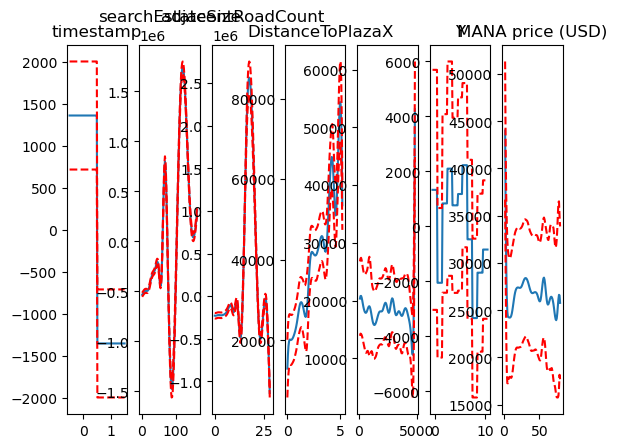

In [22]:
## plot the marginal plots 
plt.figure();
fig, axs = plt.subplots(1,7);

titles = ['timestamp', 'searchEstateSize', 'adjacentRoadCount', 'DistanceToPlaza', 'X', 'Y', 'MANA price (USD)']
for i, ax in enumerate(axs):
    XX = gam2.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam2.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam2.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
    #if i == 0:
        #ax.set_ylim(-30,30)
    ax.set_title(titles[i]);

In [27]:
scaler = StandardScaler()

# transform data to standardize it
X3 = scaler.fit_transform(X)

X3 = pd.DataFrame(X3)
X3

,0,1,2,3,4,5,6,7,8,9,10
0,0.358084,-0.162002,-0.417912,-0.659458,-0.769311,-1.160103,-0.323604,1.933789,-0.813503,-1.370068,0.313188
1,0.358084,-0.162002,-0.417912,0.306462,0.753988,1.092986,1.629919,0.213278,1.200369,1.131763,0.660421
2,0.358084,-0.162002,-0.417912,-0.133100,0.917078,-0.878467,0.848510,-1.998808,-0.716057,0.536261,1.273636
3,0.358084,-0.162002,0.579585,0.100718,1.628999,0.529713,-0.602679,-0.401190,1.200369,0.064820,-1.632428
4,0.358084,-0.162002,-0.417912,-0.702229,-0.950140,1.092986,0.234546,0.213278,1.850005,0.316994,1.182041
...,...,...,...,...,...,...,...,...,...,...,...
10712,0.358084,-0.162002,-0.417912,0.061688,1.624210,1.092986,-0.491049,1.565108,-0.293794,-1.073044,0.596472
10713,0.358084,-0.162002,-0.417912,-0.064371,0.091457,0.811350,1.574104,-0.401190,-0.943430,1.138241,-1.057634
10714,0.358084,-0.162002,0.579585,0.051485,0.178376,-0.315195,-0.491049,-0.155403,-0.716057,-1.214321,-0.622337
10715,-2.792642,-0.162002,0.579585,-0.698217,-0.868608,0.248077,-1.272458,-0.401190,0.875551,0.443882,-1.554703


In [28]:
#fit lineargam to standardized data and response in USD
gam4 = LinearGAM().fit(X3,y2)
#gam = LinearGAM()
gam4 = gam4.gridsearch(X3, y2)

100% (11 of 11) |########################| Elapsed Time: 0:00:15 Time:  0:00:15


In [29]:
gam4.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                    169.6827
Link Function:                     IdentityLink Log Likelihood:                               -222676.6074
Number of Samples:                        10717 AIC:                                             445694.58
                                                AICc:                                          445700.1376
                                                GCV:                                        433680648.0706
                                                Scale:                                      421338655.7016
                                                Pseudo R-Squared:                                   0.7673
Feature Function                  Lam

C:\Users\Bamar\AppData\Local\Temp\ipykernel_22484\3649765879.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam4.summary()


<Figure size 640x480 with 0 Axes>

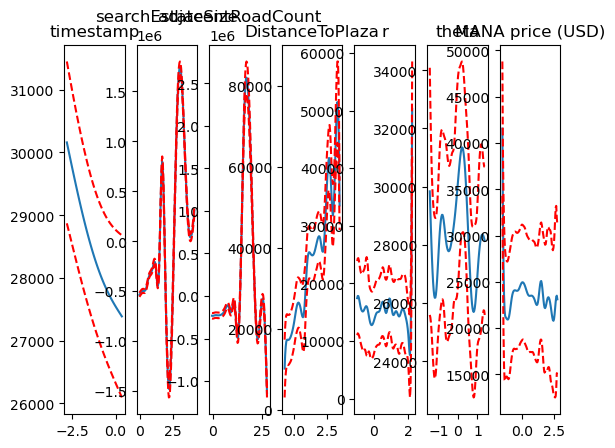

In [30]:
## plot marginal plots
plt.figure();
fig, axs = plt.subplots(1,7);

titles = ['timestamp', 'searchEstateSize', 'adjacentRoadCount', 'DistanceToPlaza', 'r', 'theta', 'MANA price (USD)']
for i, ax in enumerate(axs):
    XX = gam4.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam4.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam4.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
    #if i == 0:
        #ax.set_ylim(-30,30)
    ax.set_title(titles[i]);

In [35]:
#create test x and y
X1_test = land_data_test[['type Label','Estate Size', 'adjacentRoadCount', 'MANA price (USD)', 'ETH price (USD)',
                          'Closest Plaza Label', 'Dist to Plaza', 'Closest District Label', 'Dist to District','r','theta']]
y1_test = land_data_test[['sale price (MANA)']]

In [36]:
#predict the sale prices on X1_test
Mana_predict = gam.predict(X1_test)
mana_predict = pd.DataFrame(Mana_predict)
print(y1_test)
print(mana_predict)

#Calculate MSEs
MSE_mana = np.square(np.subtract(Mana_predict,y1_test.to_numpy())).mean()
MSE_mana

       sale price (MANA)
12827             4399.0
6289              8999.0
10999            60000.0
5859              9000.0
12461            60000.0
...                  ...
12490            23999.0
1247             45000.0
12390             8299.0
4790             24500.0
2708            585000.0

[2680 rows x 1 columns]
                  0
0     -11877.887538
1      21661.955420
2      79824.597692
3       9358.459699
4     226321.848900
...             ...
2675   41396.540771
2676   31136.849970
2677   14013.330890
2678   22414.114787
2679  157473.545625

[2680 rows x 1 columns]


5384540291.884935

In [37]:
#create y2_test for USD response
y2_test = land_data_test[['sale price (USD)']]

#predict the sale prices on X1_test
gam2_predict = gam2.predict(X1_test)

#calculat MSE
MSE_gam2 = np.square(np.subtract(gam2_predict,y2_test.to_numpy())).mean()
MSE_gam2

3700134288.6520987

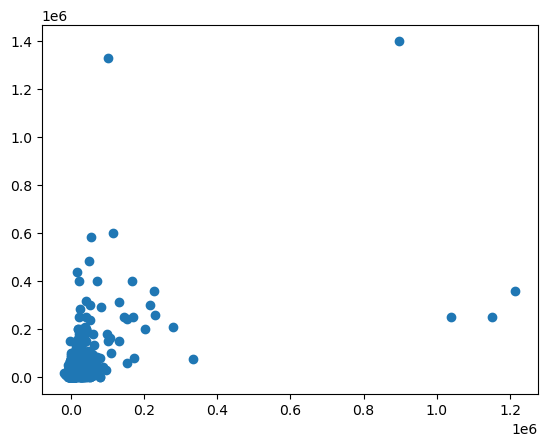

In [40]:
plt.scatter(gam2_predict,y1_test)

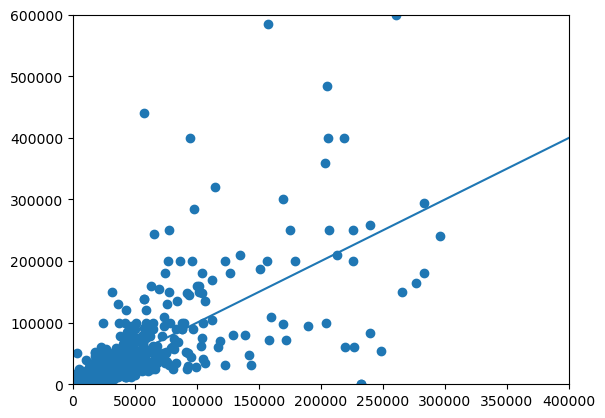

In [41]:
plt.scatter(Mana_predict,y1_test)
plt.xlim(0,400000)
plt.ylim(0,600000)
#plt1.show()
plt.axline((0, 0), slope=1)

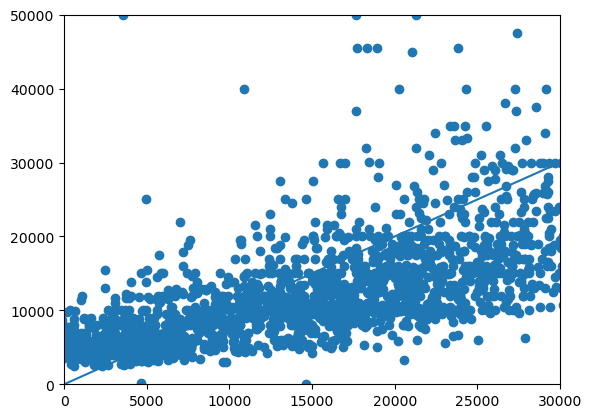

In [42]:
plt.scatter(Mana_predict,y1_test)
plt.xlim(0,30000)
plt.ylim(0,50000)
#plt1.show()
plt.axline((0, 0), slope=1)

In [43]:
#reset indexs
y1_test_0 = y1_test.reset_index(drop=True)
y2_test_0 = y2_test.reset_index(drop=True)
X1_test_0 = X1_test.reset_index(drop=True)

In [48]:
def within_10percent(x):
    """This function checks if the prediction is within 10% on actual:
    ------------
    x: This function will be used in a df.apply and each row of the df will sent through
    this function
    return:
    -------
    1 if within 10%, 0 if not
    """
    if x['Prediction'] < 1.1*x['Actual'] and x['Prediction'] > 0.9*x['Actual']:
        return 1
    else:
        return 0
    

In [146]:
#create df for baseline results
Pred_size_0 = land_data_test['Pred_size'].reset_index(drop=True)
base_results = pd.concat([y2_test_0,Pred_size_0],axis = 1)
base_results.rename(columns = {'Pred_size':'Prediction', 'sale price (USD)':'Actual'}, inplace = True)

#calculate if prediction is within 10% of actual
base_results['Within 10%'] = base_results.apply(within_10percent, axis = 1)
print(base_results['Within 10%'].sum()/base_results.shape[0])
base_results


0.04776119402985075


,Actual,Prediction,Within 10%
0,3178.354220,5707.612270,0
1,750.504755,5707.612270,0
2,171697.396222,29951.518904,0
3,708.014774,5707.612270,0
4,55336.661612,35486.244660,0
...,...,...,...
2675,20197.323624,35636.465332,0
2676,2485.527851,5707.612270,0
2677,8144.412791,12017.086395,0
2678,1417.659757,5707.612270,0


In [46]:
#create df for gam1 results
gam1_results = pd.concat([y1_test_0,pd.DataFrame(Mana_predict),X1_test_0['MANA price (USD)']], axis = 1)
gam1_results.rename(columns = {0:'Prediction', 'sale price (MANA)':'Actual'}, inplace = True)

#convert to USD to be able to directly compare different models
gam1_results['Actual (USD)'] = gam1_results['Actual']*gam1_results['MANA price (USD)']
gam1_results['Prediction (USD)'] = gam1_results['Prediction']*gam1_results['MANA price (USD)']
gam1_results


,Actual,Prediction,MANA price (USD),Actual (USD),Prediction (USD)
0,4399.0,-11877.887538,0.722517,3178.354220,-8581.980900
1,8999.0,21661.955420,0.083399,750.504755,1806.578568
2,60000.0,79824.597692,2.861623,171697.396222,228427.926302
3,9000.0,9358.459699,0.078668,708.014774,736.214192
4,60000.0,226321.848900,0.922278,55336.661612,208731.592800
...,...,...,...,...,...
2675,23999.0,41396.540771,0.841590,20197.323624,34838.923741
2676,45000.0,31136.849970,0.055234,2485.527851,1719.811284
2677,8299.0,14013.330890,0.981373,8144.412791,13752.301644
2678,24500.0,22414.114787,0.057864,1417.659757,1296.962797


In [49]:
#check % within 10%
gam1_results['Within 10%'] = gam1_results.apply(within_10percent, axis = 1)
gam1_results['Within 10%'].sum()/gam1_results.shape[0]

0.09776119402985074

In [50]:
#create df for gam2 results
y2_test_0 = y2_test.reset_index(drop=True)
gam2_results = pd.concat([y2_test_0,pd.DataFrame(gam2_predict)], axis = 1)
gam2_results.rename(columns = {0:'Prediction', 'sale price (USD)':'Actual'}, inplace = True)

#check % within 10%
gam2_results['Within 10%'] = gam2_results.apply(within_10percent, axis = 1)
gam2_results['Within 10%'].sum()/gam2_results.shape[0]

0.05970149253731343

In [53]:
#Create random forest regressor for x and y
regressor1 = RandomForestRegressor(n_estimators = 100, random_state = 0)
regressor1.fit(X, y.to_numpy().ravel()) 

RandomForestRegressor(random_state=0)

In [104]:
#get variable importance
feature_list = list(X.columns)
# Get numerical feature importances
importances = list(regressor1.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: Estate Size          Importance: 0.58
Variable: MANA price (USD)     Importance: 0.12
Variable: ETH price (USD)      Importance: 0.08
Variable: r                    Importance: 0.06
Variable: adjacentRoadCount    Importance: 0.04
Variable: Dist to Plaza        Importance: 0.03
Variable: theta                Importance: 0.03
Variable: Closest District Label Importance: 0.02
Variable: Dist to District     Importance: 0.02
Variable: type Label           Importance: 0.01
Variable: Closest Plaza Label  Importance: 0.01


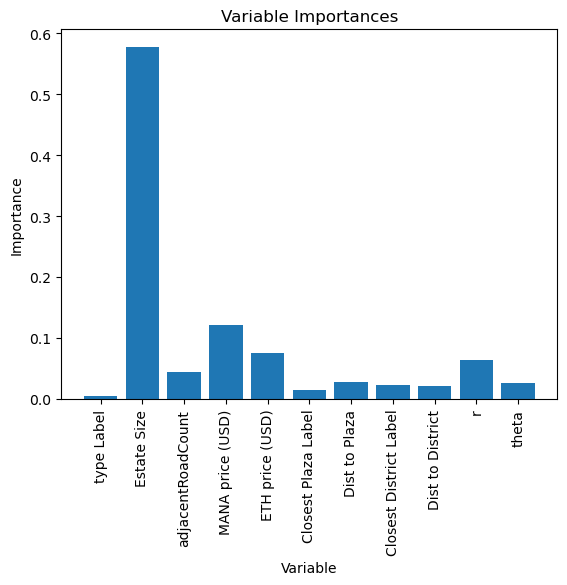

In [105]:
#plot the variable importance
# Set the style
#plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

In [55]:
#make predictions with random forest 1
RF1_predict = regressor1.predict(X1_test)
RF1_predict

array([  3852.34,  10531.6 ,  48772.38, ...,   9864.39,  22476.46,
       176656.61])

In [57]:
#create df for rf1 results
RF1_results = pd.concat([y1_test_0,pd.DataFrame(RF1_predict)], axis = 1)
RF1_results = pd.concat([y1_test_0,pd.DataFrame(RF1_predict),X1_test_0['MANA price (USD)']], axis = 1)
RF1_results.rename(columns = {0:'Prediction', 'sale price (MANA)':'Actual'}, inplace = True)

#convert to USD so can directly compare to others
RF1_results['Actual (USD)'] = RF1_results['Actual']*RF1_results['MANA price (USD)']
RF1_results['Prediction (USD)'] = RF1_results['Prediction']*RF1_results['MANA price (USD)']

#calculate % within 10%
RF1_results['Within 10%'] = RF1_results.apply(within_10percent, axis = 1)
print(RF1_results['Within 10%'].sum()/RF1_results.shape[0])
RF1_results

0.4899253731343284


,Actual,Prediction,MANA price (USD),Actual (USD),Prediction (USD),Within 10%
0,4399.0,3852.340000,0.722517,3178.354220,2783.382836,0
1,8999.0,10531.600000,0.083399,750.504755,878.321577,0
2,60000.0,48772.380000,2.861623,171697.396222,139568.177559,0
3,9000.0,9075.066667,0.078668,708.014774,713.920142,1
4,60000.0,170563.880000,0.922278,55336.661612,157307.261847,0
...,...,...,...,...,...,...
2675,23999.0,51295.520000,0.841590,20197.323624,43169.807821,0
2676,45000.0,40436.291667,0.055234,2485.527851,2233.456203,0
2677,8299.0,9864.390000,0.981373,8144.412791,9680.643944,0
2678,24500.0,22476.460000,0.057864,1417.659757,1300.570319,1


In [61]:
#create rf 2 with response as usd
regressor2 = RandomForestRegressor(n_estimators = 100, random_state = 0)
regressor2.fit(X, y2.to_numpy().ravel()) 

RandomForestRegressor(random_state=0)

In [106]:
# Get numerical feature importances
importances2 = list(regressor2.feature_importances_)
# List of tuples with variable and importance
feature_importances2 = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances2)]
# Sort the feature importances by most important first
feature_importances2 = sorted(feature_importances2, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances2];

Variable: Estate Size          Importance: 0.56
Variable: MANA price (USD)     Importance: 0.23
Variable: ETH price (USD)      Importance: 0.08
Variable: adjacentRoadCount    Importance: 0.04
Variable: Closest Plaza Label  Importance: 0.02
Variable: Dist to Plaza        Importance: 0.02
Variable: r                    Importance: 0.02
Variable: Closest District Label Importance: 0.01
Variable: Dist to District     Importance: 0.01
Variable: theta                Importance: 0.01
Variable: type Label           Importance: 0.0


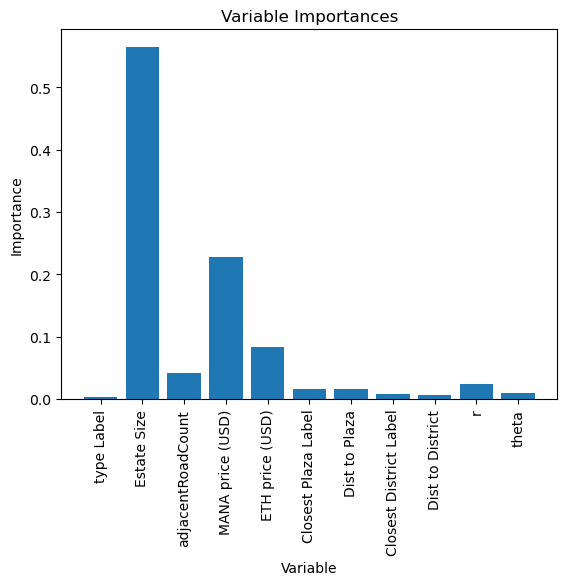

In [107]:
#plot variable importances

# Set the style
#plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances2)))
# Make a bar chart
plt.bar(x_values, importances2, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

In [111]:
feature_importances

[('Estate Size', 0.58),
 ('MANA price (USD)', 0.12),
 ('ETH price (USD)', 0.08),
 ('r', 0.06),
 ('adjacentRoadCount', 0.04),
 ('Dist to Plaza', 0.03),
 ('theta', 0.03),
 ('Closest District Label', 0.02),
 ('Dist to District', 0.02),
 ('type Label', 0.01),
 ('Closest Plaza Label', 0.01)]

In [109]:
feature_importances2

[('Estate Size', 0.56),
 ('MANA price (USD)', 0.23),
 ('ETH price (USD)', 0.08),
 ('adjacentRoadCount', 0.04),
 ('Closest Plaza Label', 0.02),
 ('Dist to Plaza', 0.02),
 ('r', 0.02),
 ('Closest District Label', 0.01),
 ('Dist to District', 0.01),
 ('theta', 0.01),
 ('type Label', 0.0)]

In [141]:
#create df of both models variable importances to plot them on one chart
df1 = pd.DataFrame(feature_importances, columns = ['Variable', 'Importance'])
df1['model'] = 'Sale price in MANA'
#df1
df2 = pd.DataFrame(feature_importances2, columns = ['Variable', 'Importance'])
df2['model'] = 'Sale price in USD'
#df = pd.merge(df1,df2, on = 'Variable', how='left')
#df
df = pd.concat([df1,df2], ignore_index = True)
df

,Variable,Importance,model
0,Estate Size,0.58,Sale price in MANA
1,MANA price (USD),0.12,Sale price in MANA
2,ETH price (USD),0.08,Sale price in MANA
3,r,0.06,Sale price in MANA
4,adjacentRoadCount,0.04,Sale price in MANA
5,Dist to Plaza,0.03,Sale price in MANA
6,theta,0.03,Sale price in MANA
7,Closest District Label,0.02,Sale price in MANA
8,Dist to District,0.02,Sale price in MANA
9,type Label,0.01,Sale price in MANA


Text(0.5, 1.0, 'Random Forest Regressor Variable Importance')

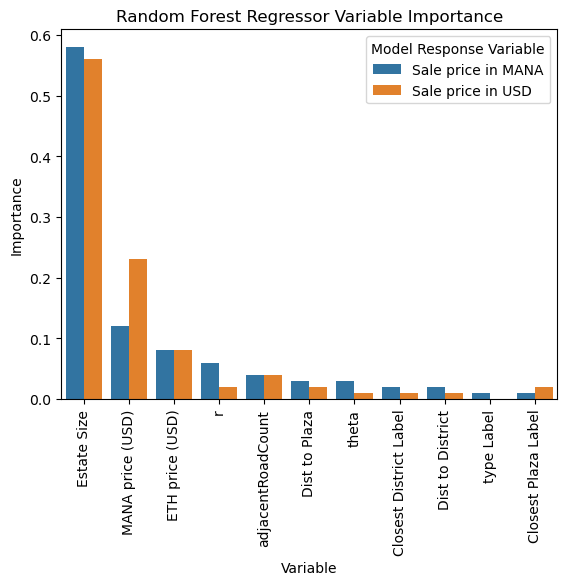

In [145]:
#plot both rf models variable importance
sns.barplot(x="Variable", hue="model", y="Importance", data=df)
plt.legend(title='Model Response Variable')#, labels=['Sale price in MANA','Sale price in USD'])
plt.xticks(rotation=90)
plt.title('Random Forest Regressor Variable Importance')
#plt.show()

In [63]:
#make predictions with rf2
RF2_predict = regressor2.predict(X1_test)
RF2_predict

array([  2924.65793432,    820.07497676, 187185.40267298, ...,
        13856.03678595,   1131.23445197,  11216.91729008])

In [64]:
#create df for rf2 results
RF2_results = pd.concat([y2_test_0,pd.DataFrame(RF2_predict)], axis = 1)
RF2_results.rename(columns = {0:'Prediction', 'sale price (USD)':'Actual'}, inplace = True)

#calculate % within 10%
RF2_results['Within 10%'] = RF2_results.apply(within_10percent, axis = 1)
RF2_results['Within 10%'].sum()/RF2_results.shape[0]

0.47201492537313433

In [68]:
RF1_results

,Actual,Prediction,MANA price (USD),Actual (USD),Prediction (USD),Within 10%
0,4399.0,3852.340000,0.722517,3178.354220,2783.382836,0
1,8999.0,10531.600000,0.083399,750.504755,878.321577,0
2,60000.0,48772.380000,2.861623,171697.396222,139568.177559,0
3,9000.0,9075.066667,0.078668,708.014774,713.920142,1
4,60000.0,170563.880000,0.922278,55336.661612,157307.261847,0
...,...,...,...,...,...,...
2675,23999.0,51295.520000,0.841590,20197.323624,43169.807821,0
2676,45000.0,40436.291667,0.055234,2485.527851,2233.456203,0
2677,8299.0,9864.390000,0.981373,8144.412791,9680.643944,0
2678,24500.0,22476.460000,0.057864,1417.659757,1300.570319,1


In [148]:
#calculate the absoulute error and percent error of all models

base_results['abs error'] = abs(base_results['Actual']-base_results['Prediction'])
base_results['Percent Error'] = base_results['abs error']/base_results['Actual']*100

gam1_results['abs error'] = abs(gam1_results['Actual']-gam1_results['Prediction'])
gam1_results['abs error (USD)'] = abs(gam1_results['Actual (USD)']-gam1_results['Prediction (USD)'])
gam1_results['Percent Error'] = gam1_results['abs error']/gam1_results['Actual']*100

gam2_results['abs error'] = abs(gam2_results['Actual']-gam2_results['Prediction']) 
gam2_results['Percent Error'] = gam2_results['abs error']/gam2_results['Actual']*100


RF1_results['abs error'] = abs(RF1_results['Actual']-RF1_results['Prediction']) 
RF1_results['abs error (USD)'] = abs(RF1_results['Actual (USD)']-RF1_results['Prediction (USD)'])
RF1_results['Percent Error'] = RF1_results['abs error']/RF1_results['Actual']*100

RF2_results['abs error'] = abs(RF2_results['Actual']-RF2_results['Prediction']) 
RF2_results['Percent Error'] = RF2_results['abs error']/RF2_results['Actual']*100

#calculate the mean absoluter error of all models to compare
print(base_results['abs error'].mean(), base_results['Percent Error'].mean())

print('\n', gam1_results['abs error'].mean(), gam1_results['Percent Error'].mean())
print(gam1_results['abs error (USD)'].mean(), gam1_results['Percent Error'].mean())
print(gam2_results['abs error'].mean(), gam2_results['Percent Error'].mean())

print('\n', RF1_results['abs error'].mean(), RF1_results['Percent Error'].mean())
print(RF1_results['abs error (USD)'].mean(), RF1_results['Percent Error'].mean())
print(RF2_results['abs error'].mean(), RF2_results['Percent Error'].mean())

#calculate the median absoluter error of all models to compare
print('\n', base_results['abs error'].median(), base_results['Percent Error'].median())

print('\n', gam1_results['abs error'].median(), gam1_results['Percent Error'].median())
print(gam1_results['abs error (USD)'].median(), gam1_results['Percent Error'].median())
print(gam2_results['abs error'].median(), gam2_results['Percent Error'].median())

print('\n', RF1_results['abs error'].median(), RF1_results['Percent Error'].median())
print(RF1_results['abs error (USD)'].median(), RF1_results['Percent Error'].median())
print(RF2_results['abs error'].median(), RF2_results['Percent Error'].median())


8928.595167709476 6497.155391485394

 11641.175414935053 2068.040806482456
9948.733397693459 2068.040806482456
8267.202619236057 1497.0105552125344

 6142.499043332435 646.4609724198484
2792.860331650114 646.4609724198484
3129.111980544427 667.1181525936908

 5007.463653294608 136.7890931358868

 6277.349939993904 55.87133967717806
1132.0893002413268 55.87133967717806
3680.2429271364194 104.39300187481959

 1004.2661 10.337626542523623
271.7015062871767 10.337626542523623
310.65617584045435 10.93008763733315


In [87]:
#checking the percent decrease of rf1 versus baseline
(RF1_results['abs error (USD)'].mean()-base_results['abs error'].mean())/base_results['abs error'].mean()

-0.6872004745213923

In [153]:
#checking percent of errors less than 1000, versus percent of sales greater than 2500
print(len(RF1_results[RF1_results['abs error (USD)']<1000])/len(RF1_results['abs error (USD)']))
print(len(land_data_test[land_data_test['sale price (USD)']>2500])/len(land_data_test['sale price (USD)']))

0.7347014925373134
0.5261194029850746


In [73]:
#looking at percent errors greater than 200% for rf1
RF1_results[RF1_results['Percent Error']>200]
#land_data_test.iloc[657,:]
#land_data[land_data['sale price (MANA)']<1000]

,Actual,Prediction,MANA price (USD),Actual (USD),Prediction (USD),Within 10%,abs error,abs error (USD),Percent Error
177,27000.0,8.620885e+04,0.035431,956.649781,3054.506573,0,59208.850000,2097.856792,219.292037
228,249500.0,8.245988e+05,0.045151,11265.068469,37231.109082,0,575098.780000,25966.040613,230.500513
264,240.0,5.530690e+03,2.452214,588.531437,13562.437225,0,5290.690000,12973.905788,2204.454167
1474,19999.0,6.054993e+04,2.962649,59250.019800,179388.196980,0,40550.930000,120138.177180,202.764788
1555,200000.0,1.023770e+06,0.034899,6979.771755,35728.402553,0,823769.940000,28748.630798,411.884970
1611,77000.0,2.793950e+05,0.603113,46439.677070,168506.663775,0,202394.990000,122066.986705,262.850636
1645,10.0,6.952280e+04,3.297564,32.975643,229255.904404,0,69512.800000,229222.928761,695128.000000
1716,32000.0,1.075256e+05,0.085671,2741.464672,9211.805338,0,75525.650000,6470.340666,236.017656
1860,1.0,5.220437e+03,0.035745,0.035745,186.604303,0,5219.436667,186.568559,521943.666667
2241,15.0,6.952280e+04,3.362912,50.443683,233799.070120,0,69507.800000,233748.626437,463385.333333


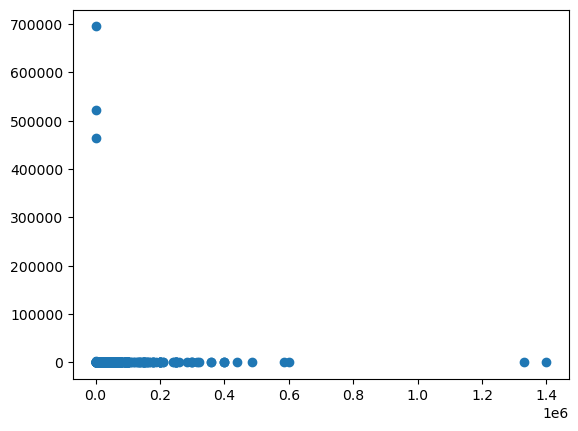

In [74]:
#scatterplot for actual vs percent error
plt.scatter(RF1_results['Actual'],RF1_results['Percent Error'])
#plt.xlim(0,30000)
#plt.ylim(0,50000)
#plt.axline((0, 0), slope=1)

(-1000.0, 1000.0)

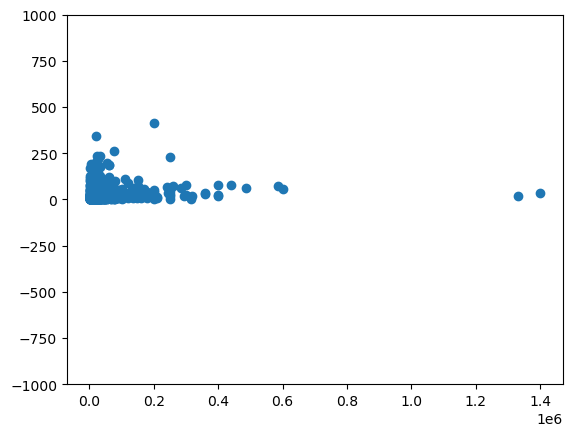

In [75]:
plt.scatter(RF1_results['Actual'],RF1_results['Percent Error'])
#plt.xlim(0,30000)
plt.ylim(-1000,1000)

In [77]:
#create GammaGam for X and y variables
ggam = GammaGAM(f(0) + s(1) + s(2) + s(3) + s(4) + f(5) + s(6) + f(7) + s(8) + s(9) + s(10)).fit(X,y)
#gam = LinearGAM()
ggam = ggam.gridsearch(X, y)


100% (11 of 11) |########################| Elapsed Time: 0:00:45 Time:  0:00:45


In [78]:
ggam.summary()

GammaGAM                                                                                                  
=============================================== ==========================================================
Distribution:                         GammaDist Effective DoF:                                    184.7213
Link Function:                          LogLink Log Likelihood:                                -104489.317
Number of Samples:                        10717 AIC:                                           209350.0765
                                                AICc:                                          209356.6629
                                                GCV:                                                0.1388
                                                Scale:                                              0.1592
                                                Pseudo R-Squared:                                   0.8824
Feature Function                  Lam

C:\Users\Bamar\AppData\Local\Temp\ipykernel_22484\2154235103.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  ggam.summary()


<Figure size 640x480 with 0 Axes>

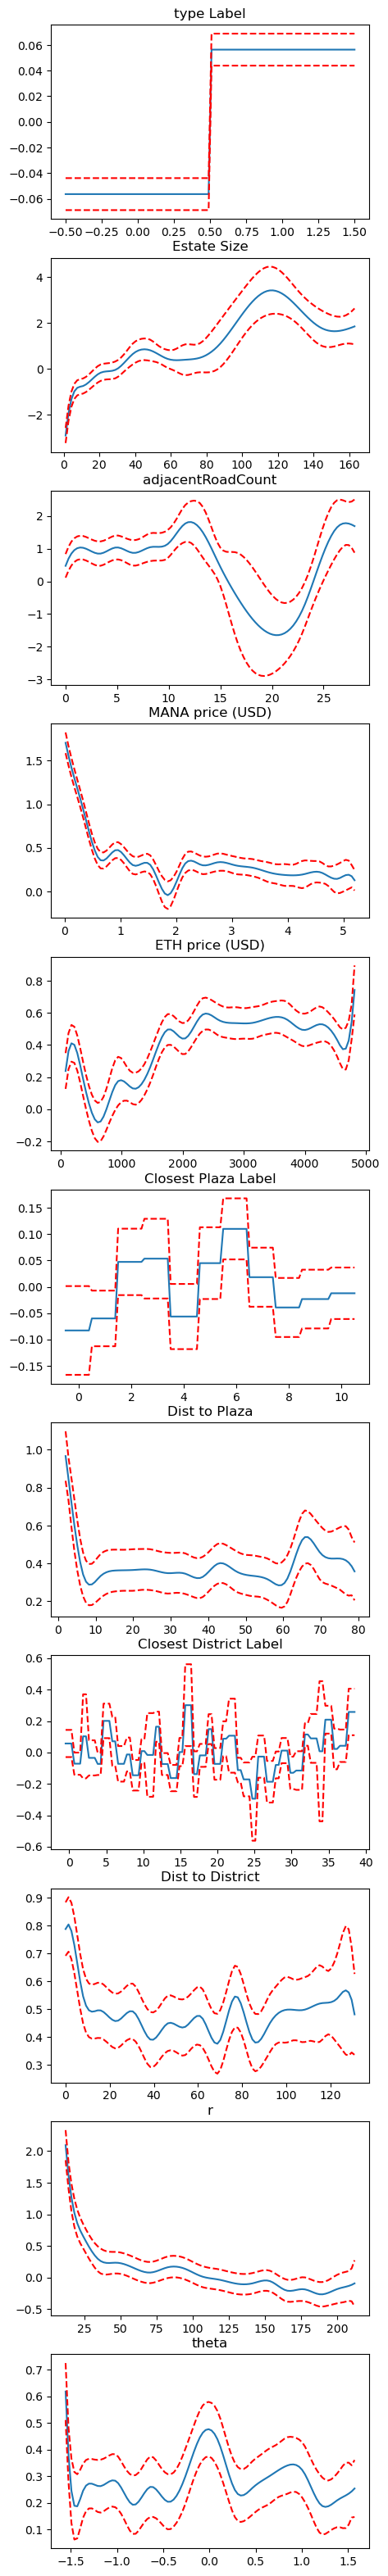

In [103]:
## plot marginal plots
plt.figure();

fig, axs = plt.subplots(11,1);
#fig.set_size_inches(10,50)
fig.set_size_inches(5,40)

titles = ['type Label','Estate Size', 'adjacentRoadCount', 'MANA price (USD)', 'ETH price (USD)',
          'Closest Plaza Label', 'Dist to Plaza', 'Closest District Label', 'Dist to District','r','theta']
for i, ax in enumerate(axs):
    XX = ggam.generate_X_grid(term=i)
    ax.plot(XX[:, i], ggam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], ggam.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
    #if i == 0:
        #ax.set_ylim(-30,30)
    ax.set_title(titles[i]);

In [79]:
#make predictions with ggam
ggam1_predict = ggam.predict(X1_test)
ggam1_predict = pd.DataFrame(ggam1_predict)
ggam1_results = pd.concat([y1_test_0,ggam1_predict], axis = 1)
ggam1_results

,sale price (MANA),0
0,4399.0,2961.609569
1,8999.0,14622.846807
2,60000.0,45431.525206
3,9000.0,10467.300008
4,60000.0,44809.819590
...,...,...
2675,23999.0,22869.199914
2676,45000.0,33163.230438
2677,8299.0,8954.877309
2678,24500.0,15928.098316


In [83]:
#make df for results
ggam1_results = pd.concat([y1_test_0,ggam1_predict,X1_test_0['MANA price (USD)']], axis = 1)
ggam1_results.rename(columns = {0:'Prediction', 'sale price (MANA)':'Actual'}, inplace = True)
ggam1_results['Actual (USD)'] = ggam1_results['Actual']*ggam1_results['MANA price (USD)']
ggam1_results['Prediction (USD)'] = ggam1_results['Prediction']*ggam1_results['MANA price (USD)']
ggam1_results

#calculate $ within 10% of actual and abs error and percent error
#ggam1_results.rename(columns = {0:'Prediction', 'sale price (MANA)':'Actual'}, inplace = True)
ggam1_results['Within 10%'] = ggam1_results.apply(within_10percent, axis = 1)
ggam1_results['Within 10%'].sum()/ggam1_results.shape[0]
ggam1_results['abs error'] = abs(ggam1_results['Actual']-ggam1_results['Prediction']) 
ggam1_results['abs error (USD)'] = abs(ggam1_results['Actual (USD)']-ggam1_results['Prediction (USD)']) 
ggam1_results['Percent Error'] = ggam1_results['abs error']/ggam1_results['Actual']*100

#calculate mean absolute error and median absoluter error
print(ggam1_results['abs error'].mean(), ggam1_results['Percent Error'].mean())
print(ggam1_results['abs error (USD)'].mean(), ggam1_results['Percent Error'].mean())

print('\n', ggam1_results['abs error'].median(), ggam1_results['Percent Error'].median())
print('\n', ggam1_results['abs error (USD)'].median(), ggam1_results['Percent Error'].median())

10300.092976421596 1033.5081225889187
3288.9055806058777 1033.5081225889187

 1978.6080140747526 19.51791985791425

 478.7564832747048 19.51791985791425


In [84]:
ggam1_results

,Actual,Prediction,MANA price (USD),Actual (USD),Prediction (USD),Within 10%,abs error,abs error (USD),Percent Error
0,4399.0,2961.609569,0.722517,3178.354220,2139.814565,0,1437.390431,1038.539655,32.675391
1,8999.0,14622.846807,0.083399,750.504755,1219.526176,0,5623.846807,469.021421,62.494131
2,60000.0,45431.525206,2.861623,171697.396222,130007.909737,0,14568.474794,41689.486485,24.280791
3,9000.0,10467.300008,0.078668,708.014774,823.444784,0,1467.300008,115.430009,16.303333
4,60000.0,44809.819590,0.922278,55336.661612,41327.097060,0,15190.180410,14009.564553,25.316967
...,...,...,...,...,...,...,...,...,...
2675,23999.0,22869.199914,0.841590,20197.323624,19246.494925,1,1129.800086,950.828700,4.707697
2676,45000.0,33163.230438,0.055234,2485.527851,1831.736286,0,11836.769562,653.791565,26.303932
2677,8299.0,8954.877309,0.981373,8144.412791,8788.072936,1,655.877309,643.660145,7.903088
2678,24500.0,15928.098316,0.057864,1417.659757,921.658122,0,8571.901684,496.001635,34.987354


In [159]:
#create table of different evaluations metrics

columns = ['Model', 'Response Variable Units', 'Mean Absolute Error (USD)', 'Median Absolute Error (USD)',
           'Percent within 10% of Actual', "Percent within $1,000 of Actual"]
row0 = ['Baseline', 'USD', round(base_results['abs error'].mean(),0),
       round(base_results['abs error'].median(),0), round(base_results['Within 10%'].sum()/base_results.shape[0]*100,1),
       round(len(base_results[base_results['abs error']<1000])/len(base_results['abs error'])*100,1)]
row1 = ['GAM Normal Distribution', 'MANA', round(gam1_results['abs error (USD)'].mean(),0),
       round(gam1_results['abs error (USD)'].median(),0), 
       round(gam1_results['Within 10%'].sum()/gam1_results.shape[0]*100,1),
       round(len(gam1_results[gam1_results['abs error (USD)']<1000])/len(gam1_results['abs error (USD)'])*100,1)]
row2 = ['GAM Normal Distribution', 'USD', round(gam2_results['abs error'].mean(),0),
       round(gam2_results['abs error'].median(),0), 
       round(gam2_results['Within 10%'].sum()/gam2_results.shape[0]*100,1),
       round(len(gam2_results[gam2_results['abs error']<1000])/len(gam2_results['abs error'])*100,1)]
row3 = ['RF', 'MANA', round(RF1_results['abs error (USD)'].mean(),0),
       round(RF1_results['abs error (USD)'].median(),0), 
       round(RF1_results['Within 10%'].sum()/RF1_results.shape[0]*100,1),
       round(len(RF1_results[RF1_results['abs error (USD)']<1000])/len(RF1_results['abs error (USD)'])*100,1)]
row4 = ['RF', 'USD', round(RF2_results['abs error'].mean(),0),
       round(RF2_results['abs error'].median(),0), 
       round(RF2_results['Within 10%'].sum()/RF2_results.shape[0]*100,1),
       round(len(RF2_results[RF2_results['abs error']<1000])/len(RF2_results['abs error'])*100,1)]

row5 = ['GAM Gamma Distribution', 'MANA', round(ggam1_results['abs error (USD)'].mean(),0),
       round(ggam1_results['abs error (USD)'].median(),0), 
       round(ggam1_results['Within 10%'].sum()/ggam1_results.shape[0]*100,1),
       round(len(ggam1_results[ggam1_results['abs error (USD)']<1000])/len(ggam1_results['abs error (USD)'])*100,1)]

pd.DataFrame([row0,row1,row2,row3,row4,row5], columns = columns)

,Model,Response Variable Units,Mean Absolute Error (USD),Median Absolute Error (USD),Percent within 10% of Actual,"Percent within $1,000 of Actual"
0,Baseline,USD,8929.0,5007.0,4.8,7.2
1,GAM Normal Distribution,MANA,9949.0,1132.0,9.8,48.7
2,GAM Normal Distribution,USD,8267.0,3680.0,6.0,13.1
3,RF,MANA,2793.0,272.0,49.0,73.5
4,RF,USD,3129.0,311.0,47.2,72.9
5,GAM Gamma Distribution,MANA,3289.0,479.0,27.0,63.7
